## Capstone Project-The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

With the COVID-19 pandemic, many businesses like offices, schools, colleges, etc. have been shut down forcing people to work/study from home. However, the food industry personnel do not have the opportunity to work from home and are required to continue with their daily work activities while adhering to the safety measures.

What’s concerning is that it can survive on different surfaces for quite a long time and once we come in contact with a contaminated surface, we can get infected too. This naturally makes us think twice before ordering food online or before visiting a restaurant to dine-in.

This would also change consumer behavior and would affect our decision while choosing any food outlet. Consumers would not only look at food outlets that serve good quality food at a good price but will also look at the hygiene rating and the area in which the food outlet is located in to ensure that safety and hygiene are not being compromised.

## Data <a name="data"></a>

The aim of this project is to cluster the food outlets in San Francisco, California based on:

1. Customer Rating
2. Inspection Score
3. Location
4. Coronavirus cases in the neighborhood
5. Online Delivery Service 
6. Price

Based on definition of our problem, factors that will influence our decision are:
* Health Aspects of food outlet looking at Location Scores and Cornavirus cases.
* Number of existing restaurants in the neighborhood (any type of restaurant)
* Number of and distance to Italian restaurants in the neighborhood, if any

We will be using data from the San Francisco Government API for Covid-19 and Health Inspection Data, the Foursquare API and the Zomato API:

- [San Francisco Neighborhood Covid-19 Data](#Covid_Data) - To get all the confirmed coronavirus cases in the different neighborhoods of San Francisco
                
- [San Francisco Government Restaurant Health Inspection Data](#SF_Data) - Using the San Francisco's LIVES restaurant inspection data leverages the LIVES Flattened Schema (https://goo.gl/c3nNvr), which is based on LIVES version 2.0, cited on Yelp's website (http://www.yelp.com/healthscores).

- [FourSquare API](#FourSquare) - Use the location coordinates of the districts we received from the Covid19 API and pass it as input to the FourSqaure API to retrieve 100 venues within 4 kms for each Neighborhood of San Francisco.

- [Zomato API](#Zomato) - Used the coordinates of the neighborhoods we receive from the FourSquare Venue Dataset, pass it to the Zomato API to retrieve Pricing for Two, Pricing Tier and Customer Rating.  Note:  Hygiene Ratings were NOT available for any of the restaurants.

In [1]:
import warnings
warnings. filterwarnings("ignore")

In [2]:
#Install Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests
import json

!pip install geopy
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
!pip install folium
import folium
print("Libraries imported!")

Libraries imported!


### San Francisco Covid19 Data <a name="Covid_Data"></a>

In [3]:
# Create URL to JSON file (alternatively this can be a filepath)
url = 'https://data.sfgov.org/resource/tpyr-dvnc.json'
# Load the first sheet of the JSON file into a data frame
df = pd.read_json(url, orient='columns')

# View the first five rows
df.head()
covid_df = df.loc[df['area_type'] == 'Analysis Neighborhood']
covid_df.rename(columns={'id': 'Neighborhood', 'count': 'Cases','rate': 'Rate of Cases per 10k'}, inplace=True)
covid_df.head()

,area_type,Neighborhood,Cases,deaths,acs_population,last_updated_at,multipolygon,Rate of Cases per 10k
1,Analysis Neighborhood,Haight Ashbury,43.0,0.0,18524,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",23.213129
25,Analysis Neighborhood,Glen Park,30.0,NaN,8641,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",34.718204
26,Analysis Neighborhood,Bernal Heights,187.0,NaN,25858,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",72.318045
27,Analysis Neighborhood,Castro/Upper Market,66.0,0.0,22284,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",29.617663
28,Analysis Neighborhood,Mission,810.0,NaN,59639,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",135.817167


In [4]:
covid_df['latitude'] = 0

In [5]:
covid_df['longitude'] = 0

In [19]:
covid_df.reset_index(drop=True)

,area_type,Neighborhood,Cases,deaths,acs_population,last_updated_at,multipolygon,Rate of Cases per 10k,latitude,longitude
0,Analysis Neighborhood,Haight Ashbury,43.0,0.0,18524,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",23.213129,0,0
1,Analysis Neighborhood,Glen Park,30.0,NaN,8641,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",34.718204,0,0
2,Analysis Neighborhood,Bernal Heights,187.0,NaN,25858,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",72.318045,0,0
3,Analysis Neighborhood,Castro/Upper Market,66.0,0.0,22284,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",29.617663,0,0
4,Analysis Neighborhood,Mission,810.0,NaN,59639,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",135.817167,0,0
5,Analysis Neighborhood,Presidio,20.0,0.0,4119,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",48.555475,0,0
6,Analysis Neighborhood,Noe Valley,77.0,NaN,23507,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",32.756200,0,0
7,Analysis Neighborhood,Oceanview/Merced/Ingleside,174.0,NaN,28217,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",61.664954,0,0
8,Analysis Neighborhood,Outer Mission,217.0,NaN,24853,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",87.313403,0,0
9,Analysis Neighborhood,Excelsior,410.0,NaN,40701,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",100.734626,0,0


Haight Ashbury  37.7700148, -122.4469519
Glen Park  37.734281, -122.4344696
Bernal Heights  37.7429861, -122.4158042
Castro/Upper Market  37.7608561, -122.434957
Mission 37.76 -122.42
Presidio  37.798745600000004, -122.46458892410745
Noe Valley 37.7515906, -122.4320814
Oceanview/Merced/Ingleside  37.7136512, -122.457483
Outer Mission 37.7524984, -122.4128258
Excelsior  37.7217943, -122.4353815
Lincoln Park  37.78462545, -122.49908597713778
Golden Gate Park  37.769368099999994, -122.48218371117709
Inner Sunset 37.76145, -122.4676432
South of Market 37.7808925, -122.4009518
Inner Richmond  37.7709169, -122.479249
Twin Peaks  37.75464, -122.44648
Portola  37.726379, -122.4085514
Seacliff  37.7885406, -122.4869164
Visitacion Valley  37.7121319, -122.4097128
Lakeshore  37.7336111 -122.4913889
Nob Hill  37.7932622, -122.415249
West of Twin Peaks  37.748 -122.463
North Beach  37.8011749, -122.4090021
McLaren Park 37.7180842 -122.4190721
Japantown 37.7855789, -122.4298089
Russian Hill  37.8000729, -122.4170942
Outer Richmond  37.7770459, -122.4654532
Bayview Hunters Point  37.72687 -122.38873
Mission Bay  37.7707742, -122.3911712
Presidio Heights  37.7887511, -122.4530266
Potrero Hill  37.7565834, -122.3991374
Marina 37.803 -122.436
Pacific Heights  37.7927171, -122.4356445
Lone Mountain/USF  37.7790963, -122.4519159
Hayes Valley  37.7766853, -122.4229361
Tenderloin  37.7842493, -122.4139933
Treasure Island 37.8233541, -122.37015310228705
Financial District/South Beach 37.7936467, -122.3989378
Western Addition 37.779559, -122.4298104
Chinatown  37.7943011, -122.4063757
Sunset/Parkside  37.75 -122.49

In [20]:
lat = [37.7700148,37.734281, 37.7429861,37.7608561, 37.76, 37.798745600000004,
      37.7515906, 37.7136512, 37.7524984, 37.7217943, 37.78462545,37.769368099999994,
      37.76145, 37.7808925, 37.7709169, 37.75464,37.726379, 37.7885406,
      37.7121319, 37.7336111, 37.7932622, 37.748,37.8011749, 37.7180842,
      37.7855789,37.8000729,37.7770459,37.72687,37.7707742,37.7887511,
      37.7565834, 37.803, 37.7927171,37.7790963, 37.7766853,37.7842493,
      37.8233541,37.7936467, 37.779559,37.7943011,37.75]

In [21]:
long = [-122.4469519, -122.4344696, -122.4158042, -122.434957, -122.42, -122.46458892410745,
        -122.4320814, -122.457483, -122.4128258, -122.4353815, -122.49908597713778, -122.48218371117709,
        -122.4676432, -122.4009518, -122.479249, -122.44648, -122.4085514, -122.4869164, -122.4097128,
        -122.4913889, -122.415249, -122.463, -122.4090021, -122.4190721, -122.4298089, -122.4170942,
        -122.4654532, -122.38873, -122.3911712, -122.4530266, -122.3991374, -122.436, -122.4356445,
        -122.4519159, -122.4229361, -122.4139933, -122.37015310228705, -122.3989378, -122.4298104,
        -122.4063757, -122.49]

In [23]:
covid_df['Latitude']=lat
covid_df['Longitude']=long

covid_df

,area_type,Neighborhood,Cases,deaths,acs_population,last_updated_at,multipolygon,Rate of Cases per 10k,latitude,longitude,Latitude,Longitude
1,Analysis Neighborhood,Haight Ashbury,43.0,0.0,18524,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",23.213129,0,0,37.770015,-122.446952
25,Analysis Neighborhood,Glen Park,30.0,NaN,8641,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",34.718204,0,0,37.734281,-122.434470
26,Analysis Neighborhood,Bernal Heights,187.0,NaN,25858,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",72.318045,0,0,37.742986,-122.415804
27,Analysis Neighborhood,Castro/Upper Market,66.0,0.0,22284,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",29.617663,0,0,37.760856,-122.434957
28,Analysis Neighborhood,Mission,810.0,NaN,59639,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",135.817167,0,0,37.760000,-122.420000
30,Analysis Neighborhood,Presidio,20.0,0.0,4119,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",48.555475,0,0,37.798746,-122.464589
31,Analysis Neighborhood,Noe Valley,77.0,NaN,23507,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",32.756200,0,0,37.751591,-122.432081
32,Analysis Neighborhood,Oceanview/Merced/Ingleside,174.0,NaN,28217,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",61.664954,0,0,37.713651,-122.457483
34,Analysis Neighborhood,Outer Mission,217.0,NaN,24853,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",87.313403,0,0,37.752498,-122.412826
35,Analysis Neighborhood,Excelsior,410.0,NaN,40701,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",100.734626,0,0,37.721794,-122.435382


In [215]:
# San Francisco latitude and longitude values
sf_lat = 37.77
sf_long = -122.42

covid_map = folium.Map(location = [sf_lat, sf_long])

for name, latitude, longitude, Cases in zip(covid_df['Neighborhood'], covid_df['Latitude'], covid_df['Longitude'], covid_df['Cases']):
    label = '{}'.format(name) + ': Cases  ' + format(Cases)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(covid_map)  

covid_map

#### Neighborhoods with least cases: Presidio (20), Treasure Island (20), Chinatown (20), Glen Park (30) and Lone Mountain/UCF (31)
#### Neighborhoods with the most cases: Mission (810), Bayview Hunters Point (705) ,Tenderloin (445), Visitacion Valley (225), Outer Mission (217)
#### Neighborhoods with NO Covid 19 Data:  Lincoln Park, Golden State Park, Seacliff and McClaren Park

### San Francisco Health Inspection Data <a name="SF_Data"></a>

In [25]:
# Create URL to JSON file (alternatively this can be a filepath)
url = 'https://data.sfgov.org/resource/pyih-qa8i.json'

# Load the first sheet of the JSON file into a data frame
health_df = pd.read_json(url, orient='columns')
health_df['business_name'].str.strip()
# View the first five rows
health_df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
0,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,6961820190304,2019-03-04T00:00:00.000,Complaint,6.961820e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91044,Chopsticks Restaurant,4615 Mission St,San Francisco,CA,94112,9104420170818,2017-08-18T00:00:00.000,Non-inspection site visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Only work with Restaurants with an inspection score
health_df = health_df[health_df['inspection_score'].notnull()]
health_df.sort_values(by='inspection_score', ascending=False)

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
141,93193,Ballast Coffee,329 West Portal Ave,San Francisco,CA,94127,9319320181101,2018-11-01T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,90010,Noeteca,1551 Dolores St,San Francisco,CA,94110,9001020190729,2019-07-29T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,95129,Homeplate Boba Cart,"24 Willie Mays Pl View Level, Section 319",San Francisco,CA,94107,9512920180911,2018-09-11T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
781,94935,94635 Baby Bull Cart,24 Willie Mays Pl Upper CF Sec 143,San Francisco,CA,94107,9493520190412,2019-04-12T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,86381,The Saratoga,1000 Larkin St,San Francisco,CA,94109,8638120190822,2019-08-22T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,71008,House of Pancakes,937 TARAVAL,San Francisco,CA,94116,7100820190820,2019-08-20T00:00:00.000,Routine - Unscheduled,7.100820e+18,...,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,90622,Taqueria Lolita,750 Phelps St,San Francisco,CA,94124,9062220180821,2018-08-21T00:00:00.000,Routine - Unscheduled,9.062220e+18,...,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,91843,Hello Sandwich & Noodle,426 Larkin St,San Francisco,CA,94102,9184320180822,2018-08-22T00:00:00.000,Routine - Unscheduled,9.184320e+18,...,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
707,1154,SUNFLOWER RESTAURANT,506 Valencia St,San Francisco,CA,94103,115420190327,2019-03-27T00:00:00.000,Routine - Unscheduled,1.154202e+17,...,46.0,37.764678,-122.421905,"{'type': 'Point', 'coordinates': [-122.421905,...",19.0,4.0,5.0,8.0,28859.0,20.0


In [27]:
#Remove duplicates
health_df = health_df.drop_duplicates(subset='business_id', keep="first")
health_df.shape

(408, 23)

In [28]:
# df['risk_category'].value_counts()
health_df['inspection_score'].describe()

count    408.000000
mean      87.473039
std        8.921677
min       46.000000
25%       82.000000
50%       88.000000
75%       94.000000
max      100.000000
Name: inspection_score, dtype: float64

#### 408 Businesses Inspections Scores range between 46 and 100

In [29]:
health_df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77901,"The Estate Kitchen, LLC",799 Bryant St,San Francisco,CA,94107,7790120180416,2018-04-16T00:00:00.000,Routine - Unscheduled,7.790120e+18,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87782,Beloved Cafe,3338 24th St,San Francisco,CA,94110,8778220180502,2018-05-02T00:00:00.000,Routine - Unscheduled,8.778220e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
def get_geocode(address):
    LatLong = []
    address = address + ', San Francisco, CA'
    geolocator = Nominatim(user_agent="SF_explorer")
    location = geolocator.geocode(address)
    if location is None:
        latitude = 0
        longitude = 0
    else:
        latitude = location.latitude
        longitude = location.longitude
    
    return latitude, longitude

In [31]:
health_df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77901,"The Estate Kitchen, LLC",799 Bryant St,San Francisco,CA,94107,7790120180416,2018-04-16T00:00:00.000,Routine - Unscheduled,7.790120e+18,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87782,Beloved Cafe,3338 24th St,San Francisco,CA,94110,8778220180502,2018-05-02T00:00:00.000,Routine - Unscheduled,8.778220e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Populate Coordinates
for index, row in health_df.iterrows():
    lat, lng = get_geocode(row['business_address'])
    row['business_longitude'] = lng
    row['business_latitude'] = lat

In [14]:
health_df.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77901,"The Estate Kitchen, LLC",799 Bryant St,San Francisco,CA,94107,7790120180416,2018-04-16T00:00:00.000,Routine - Unscheduled,7.790120e+18,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87782,Beloved Cafe,3338 24th St,San Francisco,CA,94110,8778220180502,2018-05-02T00:00:00.000,Routine - Unscheduled,8.778220e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
health_df = health_df[health_df['business_latitude'] != 0]
health_df

,business_id,business_name,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77901,"The Estate Kitchen, LLC",799 Bryant St,San Francisco,CA,94107,7790120180416,2018-04-16T00:00:00.000,Routine - Unscheduled,7.790120e+18,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87782,Beloved Cafe,3338 24th St,San Francisco,CA,94110,8778220180502,2018-05-02T00:00:00.000,Routine - Unscheduled,8.778220e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1671,Just For You Cafe Inc.,732 22ND St,San Francisco,CA,94107,167120190624,2019-06-24T00:00:00.000,Routine - Unscheduled,1.671202e+17,...,92.0,37.757948,-122.388862,"{'type': 'Point', 'coordinates': [-122.388862,...",29.0,3.0,8.0,10.0,28856.0,26.0
992,1269,STARBUCKS,201 SPEAR St,San Francisco,CA,94105,126920190716,2019-07-16T00:00:00.000,Routine - Unscheduled,1.269202e+17,...,94.0,37.790944,-122.392051,"{'type': 'Point', 'coordinates': [-122.392051,...",6.0,2.0,9.0,6.0,28855.0,8.0
995,95311,95311 C&C Concessions/Portable 130 Lemonade Sn...,24 Willie Mays Pl Promenade Lvl Sect 130,San Francisco,CA,94107,9531120190412,2019-04-12T00:00:00.000,Routine - Unscheduled,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,94910,Ike's Kitchen,800 Van Ness Ave,San Francisco,CA,94109,9491020180824,2018-08-24T00:00:00.000,Routine - Unscheduled,9.491020e+18,...,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Foursquare API Data <a name="FourSquare"></a>

In [32]:
CLIENT_ID = '0KAOUTNBE0UZIMJ0UVOCAWXBISWMGOZ0GRBX53GERNC4GOZR' 
CLIENT_SECRET = 'RMRTIYEFM4QRTZMFDAUZGAAXVZVCTHYR2ULOKXIRO4HHSI5D' 
VERSION = '20200707'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius=4000 #4 km
LIMIT=100

Your credentials:
CLIENT_ID: 0KAOUTNBE0UZIMJ0UVOCAWXBISWMGOZ0GRBX53GERNC4GOZR
CLIENT_SECRET:RMRTIYEFM4QRTZMFDAUZGAAXVZVCTHYR2ULOKXIRO4HHSI5D


In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    venues_list=[]
    LIMIT = 100
    for name, lat, lng in zip(names, latitudes, longitudes):
          # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
          # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [137]:
FS_venues = getNearbyVenues(names=covid_df['Neighborhood'], 
                                    latitudes=covid_df['Latitude'], 
                                    longitudes=covid_df['Longitude'])
FS_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Haight Ashbury,37.770015,-122.446952,458ff7cbf964a52021401fe3,Haight Street Market,37.770005,-122.447634,Supermarket
1,Haight Ashbury,37.770015,-122.446952,42a78680f964a52017251fe3,The Booksmith,37.769821,-122.449363,Bookstore
2,Haight Ashbury,37.770015,-122.446952,4a76413ff964a520b8e21fe3,Ceiba,37.770389,-122.444691,Boutique
3,Haight Ashbury,37.770015,-122.446952,4c9e95190e9bb1f777ebe85f,The Love of Ganesha,37.769753,-122.448110,Gift Shop
4,Haight Ashbury,37.770015,-122.446952,3fd66200f964a52060ed1ee3,Club Deluxe,37.769937,-122.447220,Jazz Club
...,...,...,...,...,...,...,...,...
1422,Sunset/Parkside,37.750000,-122.490000,58e5a5365f671706d7246cf5,Big Big Pan Korean Restaurant,37.753433,-122.489944,Korean Restaurant
1423,Sunset/Parkside,37.750000,-122.490000,5bc3e03a38f2160025e5beb9,Hang Out Spot,37.753435,-122.490114,Cantonese Restaurant
1424,Sunset/Parkside,37.750000,-122.490000,5b39838e237dee002c82d451,The Place,37.753326,-122.491088,Asian Restaurant
1425,Sunset/Parkside,37.750000,-122.490000,4ed7fef16c25acaabb657694,New Century Seafood Market,37.753450,-122.489769,Fish Market


In [138]:
FS_venues['Neighborhood'].value_counts()

Hayes Valley                      100
Tenderloin                         92
Chinatown                          91
Castro/Upper Market                81
Mission                            78
Haight Ashbury                     75
Outer Mission                      69
North Beach                        66
Marina                             65
Japantown                          62
South of Market                    56
Mission Bay                        52
Financial District/South Beach     48
Noe Valley                         44
Nob Hill                           43
Excelsior                          38
Glen Park                          38
Inner Sunset                       37
Pacific Heights                    36
Russian Hill                       26
Presidio Heights                   25
Lakeshore                          22
Lone Mountain/USF                  20
Outer Richmond                     20
Western Addition                   18
West of Twin Peaks                 13
Golden Gate 

In [139]:
FS_venues['Venue Category'].value_counts()

Coffee Shop                     69
Park                            43
Bakery                          31
Café                            30
Pizza Place                     30
                                ..
Theme Park Ride / Attraction     1
Dumpling Restaurant              1
Mobile Phone Shop                1
Board Shop                       1
Neighborhood                     1
Name: Venue Category, Length: 273, dtype: int64

In [258]:
FS_venues=FS_venues[FS_venues['Venue Category'].isin(['Pizza Place','Italian Restaurant'])]
#FS_venues=FS_venues[FS_venues['Venue Category'].isin(['Italian Restaurant'])]
FS_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,price
10,Haight Ashbury,37.770015,-122.446952,5849c58a6ad73d598e7f4174,Slice House by Tony Gemignani,37.769832,-122.447570,Pizza Place,,
54,Haight Ashbury,37.770015,-122.446952,44786832f964a520ca331fe3,Escape From New York Pizza,37.769416,-122.451361,Pizza Place,,
73,Haight Ashbury,37.770015,-122.446952,4b6cec46f964a5201a5e2ce3,cookwithjames,37.767981,-122.445134,Italian Restaurant,,
77,Glen Park,37.734281,-122.434470,4a415045f964a52015a51fe3,Gialina Pizzeria,37.733940,-122.434144,Pizza Place,,
88,Glen Park,37.734281,-122.434470,4ef010c00e01e1fde2099099,Manzoni,37.734678,-122.433898,Italian Restaurant,,
172,Castro/Upper Market,37.760856,-122.434957,49cbcc2bf964a5201c591fe3,Poesia Osteria Italiana,37.761012,-122.434347,Italian Restaurant,,
232,Mission,37.760000,-122.420000,5cf1f27351950e002c3655b2,flour+water pizzeria,37.761633,-122.421573,Pizza Place,,
258,Mission,37.760000,-122.420000,5bafbc473ba767002c92b61a,Prairie,37.760148,-122.419930,Italian Restaurant,,
294,Noe Valley,37.751591,-122.432081,4cccf2a372106dcb93d79f99,Patxi’s Pizza,37.751430,-122.432856,Pizza Place,,
299,Noe Valley,37.751591,-122.432081,4ab7e395f964a520597b20e3,Lupa Trattoria,37.751256,-122.434486,Italian Restaurant,,


In [141]:
FS_venues.shape

(57, 8)

In [142]:
FS_venues['rating'] = ""

In [143]:
FS_venues['price'] = ""

In [144]:
FS_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,price
10,Haight Ashbury,37.770015,-122.446952,5849c58a6ad73d598e7f4174,Slice House by Tony Gemignani,37.769832,-122.447570,Pizza Place,,
54,Haight Ashbury,37.770015,-122.446952,44786832f964a520ca331fe3,Escape From New York Pizza,37.769416,-122.451361,Pizza Place,,
73,Haight Ashbury,37.770015,-122.446952,4b6cec46f964a5201a5e2ce3,cookwithjames,37.767981,-122.445134,Italian Restaurant,,
77,Glen Park,37.734281,-122.434470,4a415045f964a52015a51fe3,Gialina Pizzeria,37.733940,-122.434144,Pizza Place,,
88,Glen Park,37.734281,-122.434470,4ef010c00e01e1fde2099099,Manzoni,37.734678,-122.433898,Italian Restaurant,,


In [226]:
FS_venues['Venue Category'].value_counts()

Pizza Place           29
Italian Restaurant    25
Name: Venue Category, dtype: int64

#### ZOMATO API <a name="Zomato"></a>

In [229]:
#Zomato Key
#7f0f807e6e503c8999b43904587c8bcd
headers = {
    'user-key': '7f0f807e6e503c8999b43904587c8bcd'
}

venues_information = []
for i,j,k,l,m,n in zip(FS_venues['Venue'],FS_venues['Venue Latitude'],FS_venues['Venue Longitude'],FS_venues['Neighborhood'],FS_venues['Neighborhood Latitude'],FS_venues['Neighborhood Longitude']):
    
    url=('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(i,j,k)
    response = requests.get(url, headers=headers).json()
    #print("Hi")
    if len(response['restaurants'])>0:
        #print(i)
        for i in range(len(response['restaurants'])):
            zom_venue=[]
            zom_venue.append(l)
            zom_venue.append(m)
            zom_venue.append(n)
            zom_venue.append(response['restaurants'][i]['restaurant']['name'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['latitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['longitude'])
            zom_venue.append(response['restaurants'][i]['restaurant']['average_cost_for_two'])
            zom_venue.append(response['restaurants'][i]['restaurant']['price_range'])
            zom_venue.append(response['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
            zom_venue.append(response['restaurants'][i]['restaurant']['location']['address'])
            zom_venue.append(response['restaurants'][i]['restaurant']['cuisines'])
            zom_venue.append(response['restaurants'][i]['restaurant']['has_online_delivery'])
            zom_venue.append(response['restaurants'][i]['restaurant']['all_reviews_count'])
            zom_venue.append(response['restaurants'][i]['restaurant']['url'])
            venues_information.append(zom_venue)
           
    else:
        venues_information.append(np.zeros(6))

In [230]:
zomato_venues=pd.DataFrame()
zomato_venues = pd.DataFrame(venues_information, 
                                 columns = ['Neighborhood','N_Lat','N_Long','Venue', 'latitude', 
                                            'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address','cuisines','online_delivery','review_count','url'])

In [231]:
zomato_venues.shape

(54, 14)

In [232]:
zomato_venues.head()

,Neighborhood,N_Lat,N_Long,Venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url
0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,"1535 Haight Street, San Francisco 94117",Pizza,0.0,0.0,https://www.zomato.com/san-francisco/big-slice...
1,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,1737 Haight Street 94117,Pizza,0.0,9.0,https://www.zomato.com/san-francisco/escape-fr...
2,0,0.000000,0.000000,0,0,0,NaN,NaN,None,None,None,NaN,NaN,None
3,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,"2842 Diamond Street, San Francisco 94131","Pizza, Italian",0.0,13.0,https://www.zomato.com/san-francisco/gialina-g...
4,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,"2788 Diamond Street, San Francisco 94131",Italian,0.0,2.0,https://www.zomato.com/san-francisco/manzoni-n...


In [245]:
final_venues = zomato_venues[zomato_venues. Venue!= 0]
final_venues = final_venues.drop_duplicates()
indexNames = final_venues[ (final_venues['Neighborhood'] == 'Presidio Heights') & (final_venues['Venue'] == 'Bruno\'s Pizzeria Cucina') ].index
final_venues.drop(indexNames , inplace=True)

In [256]:
final_venues.sort_values(by='Venue', ascending=True)

,Neighborhood,N_Lat,N_Long,Venue,latitude,longitude,price_for_two,price_range,rating,address,cuisines,online_delivery,review_count,url
21,Nob Hill,37.793262,-122.415249,Allegro Romano,37.7969250000,-122.4153990000,60.0,3.0,3.9,"1701 Jones Street, San Francisco 94109",Italian,0.0,7.0,https://www.zomato.com/san-francisco/allegro-r...
36,Russian Hill,37.800073,-122.417094,Amarena,37.7978710000,-122.4204650000,60.0,3.0,3.5,"2162 Larkin Street, San Francisco 94109",Italian,0.0,7.0,https://www.zomato.com/san-francisco/amarena-r...
43,Marina,37.803000,-122.436000,Amici's East Coast Pizzeria,37.7998055901,-122.4380189180,50.0,2.0,3.9,2200 Lombard Street 94123,"Pizza, Italian",0.0,5.0,https://www.zomato.com/san-francisco/amicis-ea...
46,Hayes Valley,37.776685,-122.422936,An the Go,37.7771250000,-122.4196440000,15.0,1.0,3.6,"Various Locations, San Francisco",Asian,0.0,3.0,https://www.zomato.com/san-francisco/an-the-go...
10,Noe Valley,37.751591,-122.432081,Bacco,37.7514100000,-122.4361200000,80.0,3.0,3.7,737 Diamond Street 94114,"Italian, Seafood",0.0,2.0,https://www.zomato.com/san-francisco/bacco-ris...
50,Financial District/South Beach,37.793647,-122.398938,Barbacco,37.7934100000,-122.3990300000,70.0,3.0,4.0,220 California Street 94111,Italian,0.0,18.0,https://www.zomato.com/san-francisco/barbacco-...
0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,"1535 Haight Street, San Francisco 94117",Pizza,0.0,0.0,https://www.zomato.com/san-francisco/big-slice...
51,Western Addition,37.779559,-122.429810,Bruno's Pizzeria Cucina,37.7821361111,-122.4323805556,40.0,2.0,2.9,"1375 Fillmore Street, San Francisco 94115","Italian, Pizza",0.0,0.0,https://www.zomato.com/san-francisco/brunos-pi...
52,Chinatown,37.794301,-122.406376,Caffe Macaroni,37.7961166667,-122.4044638889,40.0,2.0,3.4,"59 Columbus Avenue, San Francisco 94133","Pizza, Italian",0.0,10.0,https://www.zomato.com/san-francisco/caffe-mac...
17,South of Market,37.780893,-122.400952,Escape From New York Pizza,37.7818200000,-122.3981500000,30.0,2.0,0,715 Harrison Street 94107,Pizza,0.0,2.0,https://www.zomato.com/san-francisco/escape-fr...


#### Map out the Italian Restaurants

In [263]:
# San Francisco latitude and longitude values
sf_lat = 37.77
sf_long = -122.42

sf_map = folium.Map(location = [sf_lat, sf_long])

for name, latitude, longitude in zip(final_venues['Venue'], final_venues['latitude'], final_venues['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(sf_map)

sf_map

In [180]:
#Eliminate Duplicates
z_venues = z_venues.drop_duplicates(subset='Venue', keep='first')
z_venues

,Venue,rating,price_range,price_for_two,online_delivery
0,Big Slice,0,1.0,0.0,0.0
1,Escape From New York Pizza,4.1,2.0,30.0,0.0
2,0,0,0.0,0.0,NaN
3,Gialina,4.3,2.0,50.0,0.0
4,Manzoni,3.6,3.0,75.0,0.0
5,Poesia,3.8,3.0,65.0,0.0
6,Farina Pizza,3.1,2.0,50.0,0.0
8,Patxi's Pizza,3.5,2.0,45.0,0.0
9,Lupa,3.9,3.0,75.0,0.0
10,Bacco,3.7,3.0,80.0,0.0


In [183]:
#Eliminate Duplicates
FS_venues = FS_venues.drop_duplicates(subset='Venue', keep='first')
FS_venues.shape

(54, 10)

In [190]:
# final_venues = pd.merge(FS_venues, z_venues, on='Venue')
# final_venues = pd.concat([FS_venues, z_venues], axis=1, join='inner')
final_venues = pd.merge(FS_venues,covid_df,how='left', on=['Venue'])
final_venues.shape

(54, 14)

In [192]:
# sort Brand - ascending order
final_venues.sort_values(by=['Venue'], inplace=True)
final_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,rating_x,price,rating_y,price_range,price_for_two,online_delivery
21,Nob Hill,37.793262,-122.415249,4a1f4d62f964a5201c7c1fe3,Allegro Romano,37.796834,-122.415420,Italian Restaurant,,,3.9,3.0,60.0,0.0
36,Russian Hill,37.800073,-122.417094,49f75320f964a520826c1fe3,Amarena,37.798004,-122.420480,Italian Restaurant,,,3.5,3.0,60.0,0.0
43,Marina,37.803000,-122.436000,4a764118f964a520b6e21fe3,Amici's East Coast Pizzeria,37.799806,-122.438019,Pizza Place,,,3.9,2.0,50.0,0.0
30,North Beach,37.801175,-122.409002,5b99e024780eee002cd0e723,Barbara Pinseria,37.799158,-122.408795,Pizza Place,,,NaN,NaN,NaN,NaN
51,Western Addition,37.779559,-122.429810,4a616c3cf964a5206ac21fe3,Bruno's Pizzeria Cucina,37.782091,-122.432528,Pizza Place,,,2.9,2.0,40.0,0.0
52,Chinatown,37.794301,-122.406376,4aca5050f964a52060c120e3,Caffè Macaroni,37.796229,-122.404355,Italian Restaurant,,,NaN,NaN,NaN,NaN
26,North Beach,37.801175,-122.409002,50086129e4b038aa4f935f9e,Capo's,37.798644,-122.408362,Pizza Place,,,NaN,NaN,NaN,NaN
38,Mission Bay,37.770774,-122.391171,59bb27f1f8cbd422291b5dd4,Casey’s Pizza,37.773783,-122.391495,Pizza Place,,,NaN,NaN,NaN,NaN
46,Hayes Valley,37.776685,-122.422936,5b12f114088158002cd23509,Del Popolo Truck,37.776583,-122.424263,Pizza Place,,,NaN,NaN,NaN,NaN
1,Haight Ashbury,37.770015,-122.446952,44786832f964a520ca331fe3,Escape From New York Pizza,37.769416,-122.451361,Pizza Place,,,4.1,2.0,30.0,0.0


In [270]:
final_venues = pd.merge(final_venues, covid_df, on='Neighborhood', how='left')
final_venues

,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,address,...,Cases,deaths,acs_population,last_updated_at,multipolygon,Rate of Cases per 10k,latitude_y,longitude_y,Latitude,Longitude
0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,"1535 Haight Street, San Francisco 94117",...,43.0,0.0,18524,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",23.213129,0,0,37.770015,-122.446952
1,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,1737 Haight Street 94117,...,43.0,0.0,18524,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",23.213129,0,0,37.770015,-122.446952
2,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,"2842 Diamond Street, San Francisco 94131",...,30.0,NaN,8641,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",34.718204,0,0,37.734281,-122.434470
3,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,"2788 Diamond Street, San Francisco 94131",...,30.0,NaN,8641,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",34.718204,0,0,37.734281,-122.434470
4,Castro/Upper Market,37.760856,-122.434957,Poesia,37.7610100000,-122.4344100000,65.0,3.0,3.8,4072 18th Street 94114,...,66.0,0.0,22284,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",29.617663,0,0,37.760856,-122.434957
5,Mission,37.760000,-122.420000,Farina Pizza,37.7615583333,-122.4216222222,50.0,2.0,3.1,"700 Valencia Street, San Francisco 94110",...,810.0,NaN,59639,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",135.817167,0,0,37.760000,-122.420000
6,Noe Valley,37.751591,-122.432081,Patxi's Pizza,37.7514630000,-122.4328760000,45.0,2.0,3.5,"4042 24th Street, San Francisco 94114",...,77.0,NaN,23507,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",32.756200,0,0,37.751591,-122.432081
7,Noe Valley,37.751591,-122.432081,Lupa,37.7512500000,-122.4345083333,75.0,3.0,3.9,"4109 24th Street, San Francisco 94114",...,77.0,NaN,23507,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",32.756200,0,0,37.751591,-122.432081
8,Noe Valley,37.751591,-122.432081,Bacco,37.7514100000,-122.4361200000,80.0,3.0,3.7,737 Diamond Street 94114,...,77.0,NaN,23507,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",32.756200,0,0,37.751591,-122.432081
9,Outer Mission,37.752498,-122.412826,The Pizza Shop,37.7525416667,-122.4143222222,25.0,1.0,0,"3104 24th Street, San Francisco",...,217.0,NaN,24853,2020-07-21 15:00:16.553,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",87.313403,0,0,37.752498,-122.412826


In [107]:
health_df = health_df.rename({'business_name': 'Venue'}, axis=1)

In [271]:
health_df.head()

,business_id,Venue,business_address,business_city,business_state,business_postal_code,inspection_id,inspection_date,inspection_type,violation_id,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,9797520190725,2019-07-25T00:00:00.000,Routine - Unscheduled,9.797520e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,6948720180418,2018-04-18T00:00:00.000,Routine - Unscheduled,6.948720e+18,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,8598720180412,2018-04-12T00:00:00.000,Routine - Unscheduled,8.598720e+18,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,77901,"The Estate Kitchen, LLC",799 Bryant St,San Francisco,CA,94107,7790120180416,2018-04-16T00:00:00.000,Routine - Unscheduled,7.790120e+18,...,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87782,Beloved Cafe,3338 24th St,San Francisco,CA,94110,8778220180502,2018-05-02T00:00:00.000,Routine - Unscheduled,8.778220e+18,...,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
final_df = pd.merge(final_venues, health_df, on='Venue', how='left')
final_df.shape

(47, 47)

In [273]:
final_df.head()

,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,address,...,inspection_score,business_latitude,business_longitude,business_location,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_bh8s_q3mv,:@computed_region_ajp5_b2md
0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,"1535 Haight Street, San Francisco 94117",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,1737 Haight Street 94117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,"2842 Diamond Street, San Francisco 94131",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,"2788 Diamond Street, San Francisco 94131",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Castro/Upper Market,37.760856,-122.434957,Poesia,37.7610100000,-122.4344100000,65.0,3.0,3.8,4072 18th Street 94114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
final_venues = final_df.filter(['Neighborhood', 'N_Lat', 'N_Long','Venue', 'latitude_x','longitude_x','price_for_two', 'price_range', 'rating', 'online_delivery','inspection_score','Cases'])

In [292]:
final_venues

,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,0.0,NaN,43.0
1,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,0.0,NaN,43.0
2,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,0.0,NaN,30.0
3,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,0.0,NaN,30.0
4,Castro/Upper Market,37.760856,-122.434957,Poesia,37.7610100000,-122.4344100000,65.0,3.0,3.8,0.0,NaN,66.0
5,Mission,37.760000,-122.420000,Farina Pizza,37.7615583333,-122.4216222222,50.0,2.0,3.1,0.0,NaN,810.0
6,Noe Valley,37.751591,-122.432081,Patxi's Pizza,37.7514630000,-122.4328760000,45.0,2.0,3.5,0.0,NaN,77.0
7,Noe Valley,37.751591,-122.432081,Lupa,37.7512500000,-122.4345083333,75.0,3.0,3.9,0.0,NaN,77.0
8,Noe Valley,37.751591,-122.432081,Bacco,37.7514100000,-122.4361200000,80.0,3.0,3.7,0.0,NaN,77.0
9,Outer Mission,37.752498,-122.412826,The Pizza Shop,37.7525416667,-122.4143222222,25.0,1.0,0,0.0,NaN,217.0


## Methodology <a name = "methodology"></a>

We will be performing Exploratory Data Analysis and Clustering of the food outlets based on ratings, avg. price, location, and number of coronavirus cases.

### Exploratory Data Analysis

In [197]:
import seaborn as sns

##### Ratings

Text(0.5, 1.0, 'Distribution of rating of restaurants')

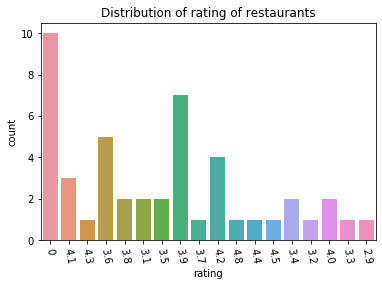

In [276]:
ax=sns.countplot(final_venues['rating'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)
ax.set_title("Distribution of rating of restaurants")

##### Price

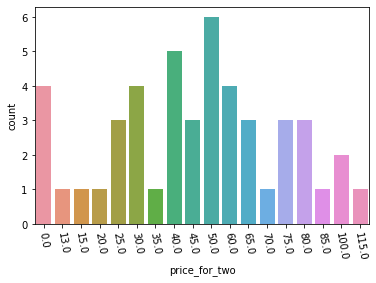

In [277]:
ax=sns.countplot(final_venues['price_for_two'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

#### Pay about $25 per person.

##### Neighborhood

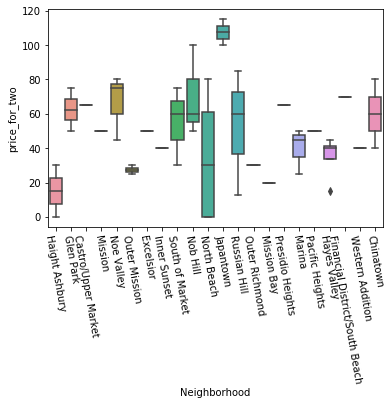

In [278]:
ax=sns.boxplot(final_venues['Neighborhood'],final_venues['price_for_two'])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

##### Haight Ashbury, North Beach, Russian Hill, Finacial District/South Beach, Pacific Heights seem to have the most wallet friendly Italian/Pizza places.

In [279]:
final_venues['rating']=final_venues['rating'].apply(lambda x: float(x))

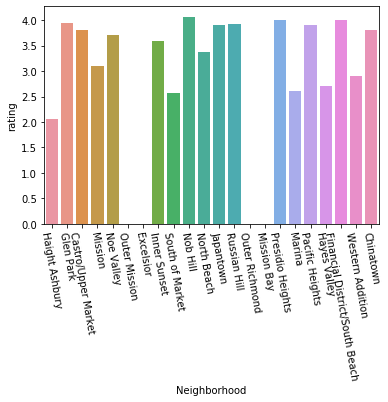

In [280]:
ax=sns.barplot(final_venues['Neighborhood'],final_venues['rating'],ci=None)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

###### Let's do a groupby() to understand the above chart better.

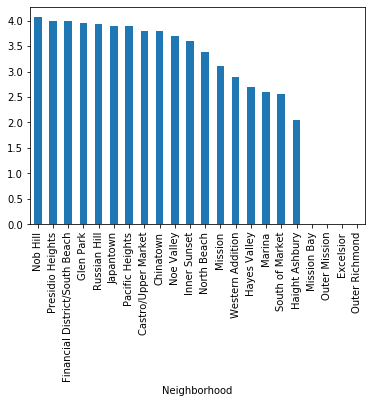

In [281]:
final_venues.groupby(['Neighborhood']).mean()['rating'].sort_values(ascending=False).plot(kind='bar')

##### Nob Hill, Presidio Heights, Financial District/South Beach, Glen Park and Russan Hill are top rated sections.

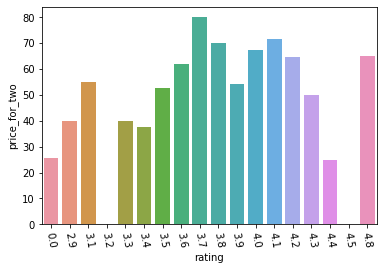

In [282]:
ax=sns.barplot(final_venues['rating'],final_venues['price_for_two'],ci=None)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-80)

## Analysis <a name="analysis"></a>

###### We will now cluster all these venues based on their price, location and more to identify similar venues and the relationship amongst them.

In [283]:
final_venues.head()

,Neighborhood,N_Lat,N_Long,Venue,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
0,Haight Ashbury,37.770015,-122.446952,Big Slice,0.0,1.0,0.0,0.0,NaN,43.0
1,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,30.0,2.0,4.1,0.0,NaN,43.0
2,Glen Park,37.734281,-122.434470,Gialina,50.0,2.0,4.3,0.0,NaN,30.0
3,Glen Park,37.734281,-122.434470,Manzoni,75.0,3.0,3.6,0.0,NaN,30.0
4,Castro/Upper Market,37.760856,-122.434957,Poesia,65.0,3.0,3.8,0.0,NaN,66.0


##### Let's select the features relevant for clustering.

In [293]:
# df_clustering=final_venues[["Cases","latitude","longitude","rating","price_for_two"]]
df_clustering=final_venues[["Cases","latitude_x","longitude_x","rating","price_for_two"]]

We will first use the "Elbow Method" to identify the optimal number of clusters.

#### Elbow Method

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.

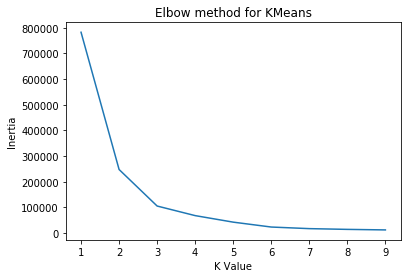

In [294]:
sum_squared_distance=[]

for k in range(1,10):
    kmeans=KMeans(n_clusters=k).fit(df_clustering)
    kmeans.predict(df_clustering)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,10),sum_squared_distance)
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()

Clustering using optimal 'k'

In [295]:
kmeans=KMeans(n_clusters=3).fit(df_clustering)
kmeans.predict(df_clustering)
final_venues.insert(0,'cluster_label',kmeans.labels_)
final_venues.head()

,cluster_label,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
0,0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,0.0,NaN,43.0
1,0,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,0.0,NaN,43.0
2,0,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,0.0,NaN,30.0
3,0,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,0.0,NaN,30.0
4,0,Castro/Upper Market,37.760856,-122.434957,Poesia,37.7610100000,-122.4344100000,65.0,3.0,3.8,0.0,NaN,66.0


Plot clusters on San Francisco Map

In [298]:
sf_map = folium.Map(location=[sf_lat,sf_long],zoom_start=10)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

for venue, cluster, latitude, longitude in zip(final_venues['Venue'], final_venues['cluster_label'], 
                                               final_venues['latitude_x'], 
                                                final_venues['longitude_x']):
    label = folium.Popup(str(venue) + ', Cluster:' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(sf_map)
sf_map

Most of the restaurants fall in Cluster 1. Let's look at our 3 clusters in detail.

Cluster 0

In [299]:
cluster1=final_venues[final_venues['cluster_label']==0]
print("Cluster 0 has: mean price of {:.02f} dollars for two, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}".format(
cluster1['price_for_two'].astype(float).mean(),
cluster1['rating'].astype(float).mean(),
cluster1['Cases'].astype(float).mean()
))
cluster1.head()

Cluster 0 has: mean price of 49.08 dollars for two, avg. rating of 3.26, avg. coronoavirus cases of 65.20


,cluster_label,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
0,0,Haight Ashbury,37.770015,-122.446952,Big Slice,37.7700111111,-122.4475166667,0.0,1.0,0,0.0,NaN,43.0
1,0,Haight Ashbury,37.770015,-122.446952,Escape From New York Pizza,37.7693200000,-122.4515600000,30.0,2.0,4.1,0.0,NaN,43.0
2,0,Glen Park,37.734281,-122.434470,Gialina,37.7338916667,-122.4339527778,50.0,2.0,4.3,0.0,NaN,30.0
3,0,Glen Park,37.734281,-122.434470,Manzoni,37.7347190000,-122.4339040000,75.0,3.0,3.6,0.0,NaN,30.0
4,0,Castro/Upper Market,37.760856,-122.434957,Poesia,37.7610100000,-122.4344100000,65.0,3.0,3.8,0.0,NaN,66.0


##### This cluster of food outlets seem to have the best combination of pricing, rating and low Covid Cases.
##### Escape From New York Pizza and Gialina seem like very good deals.

Cluster 1

In [300]:

cluster2=final_venues[final_venues['cluster_label']==1]
print("Cluster 1 has: mean price of {:.02f} dollars for two, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}".format(
cluster2['price_for_two'].astype(float).mean(),
cluster2['rating'].astype(float).mean(),
cluster2['Cases'].astype(float).mean()
))
cluster2.head()

Cluster 1 has: mean price of 50.00 dollars for two, avg. rating of 3.10, avg. coronoavirus cases of 810.00


,cluster_label,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
5,1,Mission,37.76,-122.42,Farina Pizza,37.7615583333,-122.4216222222,50.0,2.0,3.1,0.0,NaN,810.0


##### Decent Price but very high in Covid 19 Cases.  Rating is also not near the top.

Cluster 2

In [301]:
cluster3=final_venues[final_venues['cluster_label']==2]
print("Cluster 2 has: mean price of {:.02f} dollars, avg. rating of {:.02f}, avg. coronoavirus cases of {:.02f}".format(
cluster3['price_for_two'].astype(float).mean(),
cluster3['rating'].astype(float).mean(),
cluster3['Cases'].astype(float).mean()
))
cluster3.head()

Cluster 2 has: mean price of 45.00 dollars, avg. rating of 1.28, avg. coronoavirus cases of 244.67


,cluster_label,Neighborhood,N_Lat,N_Long,Venue,latitude_x,longitude_x,price_for_two,price_range,rating,online_delivery,inspection_score,Cases
9,2,Outer Mission,37.752498,-122.412826,The Pizza Shop,37.7525416667,-122.4143222222,25.0,1.0,0,0.0,NaN,217.0
10,2,Outer Mission,37.752498,-122.412826,Iron & Gold,37.7458944444,-122.4196472222,30.0,2.0,0,0.0,NaN,217.0
11,2,Excelsior,37.721794,-122.435382,North Beach Pizza,37.7218100000,-122.4368390000,50.0,2.0,0,0.0,NaN,410.0
13,2,South of Market,37.780893,-122.400952,Zero Zero,37.7814800000,-122.4019900000,60.0,3.0,3.9,0.0,NaN,208.0
14,2,South of Market,37.780893,-122.400952,Pazzia,37.7832666667,-122.3982916667,75.0,3.0,3.8,0.0,NaN,208.0


#####  These restuarants are in Neighborhoods of above average cases of Covid 19.  
#####  Prices are fairly affordable.

## Results and Discussion <a name="results"></a>

From our analysis, we noticed that most of the restaurants have an average rating of 3.8. We also noticed that the avg. price of most restaurants is about 25 dollars per person which is not that expensive for San Francisco.

Zomato’s “price range” feature was also able to give us valuable insights. This feature ranges from 1 to 4(1 being the pocket friendly to 4 being expensive) and turns out that most of the restaurants fall somehwere in the middle with respect to pricing.

An interesting yet concerning observation was made regarding the “hygiene rating” of the restaurants. All the restaurants had a hygiene rating of 0 which means these restaurants were not rated in terms of hygiene. Zomato should work on ensuring that hygiene ratings are present for all restaurants especially with this pandemic in place as it would help consumers ensure their safety and hygiene is not being compromised.



The restaurants located in the first cluster i.e. Cluster 0 have a decent price, highest rating, and a few coronavirus cases so ideally people can visit these food outlets with proper safety precautions. Interestingly enough, most of the outlets in Cluster 0 fall in Haight Ashbury.

The outlets in Cluster 1 have the highest price (although not by much), decent ratings,  but this cluster also has the highest number of coronavirus cases when compared to other clusters. Food outlets in this cluster must be extra careful while preparing and delivering food. If you do order food from here, I would recommend you take extra precautions and be very careful.

Finally, the outlets located in the last cluster i.e. Cluster 2 have the lowest price point, low ratings but it has moderate coronavirus cases. If you are on a tight budget these would be good candidates.

## Conclusion<a name="conclusion"></a>

The purpose of this project was to explore the different food outlets in San Francisco keeping in mind rating and coronavirus cases. Data has been merged from the Foursquare API and the San Francisco Government Data (Covid and Health Inspections). 

After merging data from the different sources, we have then performed Exploratory Data Analysis to reveal a few interesting observations and we have also performed K Means clustering on the dataset based on rating, avg. price, location, coronavirus cases in the Neighborhood in which the outlet is present, whether it provides online delivery and the total reviews present for that food outlet.

The clustering exercise revealed that restaurants in San Francisco and some in {Neighborhood} are safe to order from and also provide the best quality food while resturants in {Bad Neighborhood} are also safe to order from but are more on the higher end in terms of price. Based on the visitor's choice of rating, price and other requirements, he/she can choose amongst different food outlets located in these three clusters.